In [2]:
import scipy.io as sio
import numpy as np
import copy

In [13]:
bodyfat = sio.loadmat('bodyfat_data.mat')
X = bodyfat['X']
y = bodyfat['y']

x_train = X[:150,]
x_test = X[150:X.shape[0],]
y_train = y[:150,]
y_test = y[150:y.shape[0],]
np.random.seed(0)

In [14]:
# Create the model architecture
input_dim = 2
nodes_hidden_1 = 64
nodes_hidden_2 = 16
output_dim = 1

In [5]:
W = {
    'W_input_h1': np.random.randn(input_dim, nodes_hidden_1),
    'b_input_h1': np.zeros(nodes_hidden_1),

    'W_h1_h2': np.random.randn(nodes_hidden_1, nodes_hidden_2),
    'b_h1_h2': np.zeros(nodes_hidden_2),

    'W_h2_output': np.random.randn(nodes_hidden_2, output_dim),
    'b_h2_output': np.zeros(output_dim)
}

In [12]:
def relu(x):
    return np.maximum(x, 0)

def reluDerivative(x):
    y = copy.deepcopy(x)
    y[y<=0] = 0
    y[y>0] = 1
    return y


def mean_square_loss(t_hat, t):
    return np.mean(np.square(t_hat-t))

def predict(W,X):
    z_h1 = np.dot(X, W['W_input_h1']) + W['b_input_h1']
    a_h1 = relu(z_h1)

    z_h2 = np.dot(a_h1, W['W_h1_h2']) + W['b_h1_h2']
    a_h2 = relu(z_h2)
    prediction = np.dot(a_h2, W['W_h2_output']) + W['b_h2_output']
    return prediction

def early_stopping(n,lst1):
    compare = []
    for i in range(1,n+1):
        compare.append(lst1[(-1)*i]<lst1[(-1*i)-1])
    return compare
    

In [15]:
# Train using Gradient Descent
learning_rate = 1e-07
train_loss_lst = [1e+15,5e+14,1e+14,5e+13,1e+13,5e+12]
test_loss_lst = [1e+15,5e+14,1e+14,5e+13,1e+13,5e+12]
epoch=0


while sum(early_stopping(5,test_loss_lst))>=1 or abs(test_loss_lst[-1]-test_loss_lst[-2])>1e-07:    
    ## forward pass
    z_h1 = np.dot(x_train, W['W_input_h1']) + W['b_input_h1']
    a_h1 = relu(z_h1)

    z_h2 = np.dot(a_h1, W['W_h1_h2']) + W['b_h1_h2']
    a_h2 = relu(z_h2)
    forward_output = np.dot(a_h2, W['W_h2_output']) + W['b_h2_output']

    # Backward Pass
    ## the third layer
    delta_y = 2*(forward_output - y_train)
    print(delta_y.shape)
    
    N = len(delta_y)
    #print(N)
    W_h2_output_grad = np.dot(a_h2.T,delta_y).reshape((nodes_hidden_2, output_dim))
    b_h2_output_grad = np.sum(delta_y)

    ## the second layer
    delta_h2 = np.dot(delta_y,W['W_h2_output'].T)*reluDerivative(z_h2)
    print(delta_h2.shape)
    b_h1_h2_grad = np.sum(delta_h2, axis=0)
    
    W_h1_h2_grad = np.dot(a_h1.T,delta_h2)
    
    ## the first layer
    delta_h1 = np.dot(delta_h2,W['W_h1_h2'].T)*reluDerivative(z_h1)
    print(delta_h1.shape)
    b_input_h1_grad = np.sum(delta_h1, axis=0)
    
    W_input_h1_grad = np.dot(x_train.T,delta_h1)

    # Gradient Descent
    W['W_h2_output'] -= (learning_rate * W_h2_output_grad)/N
    W['b_h2_output'] -= (learning_rate * b_h2_output_grad)/N

    W['W_h1_h2'] -= (learning_rate * W_h1_h2_grad)/N
    W['b_h1_h2'] -= (learning_rate * b_h1_h2_grad)/N

    W['W_input_h1'] -= (learning_rate * W_input_h1_grad)/N
    W['b_input_h1'] -= (learning_rate * b_input_h1_grad)/N

    y_predict = predict(W,x_test)
    train_loss = mean_square_loss(forward_output, y_train)
    test_loss = mean_square_loss(y_predict, y_test)
    train_loss_lst.append(train_loss)
    test_loss_lst.append(test_loss)
    
    epoch = epoch+1
    #if epoch % 100 == 0:
        #print("Train loss after epoch ", epoch, " : ", train_loss,"\nTest loss after epoch ", epoch, " : ", test_loss,)


(150, 1)
(150, 16)
(150, 64)
(150, 1)
(150, 16)
(150, 64)
(150, 1)
(150, 16)
(150, 64)
(150, 1)
(150, 16)
(150, 64)
(150, 1)
(150, 16)
(150, 64)
(150, 1)
(150, 16)
(150, 64)


In [16]:
train_error = train_loss_lst[-1]
print ('the mean squared error on the train inputs is ', train_error)

test_error = test_loss_lst[-1]
print ('the mean squared error on the test inputs is ', test_error)


('the mean squared error on the train inputs is ', 47.871719461769835)
('the mean squared error on the test inputs is ', 55.85143849748683)


## EM

In [15]:
import numpy as np 
import matplotlib.pyplot as plt
np.random.seed(0) 
from scipy.stats import norm 

In [72]:
def LogLikelihood(n,K,ee,y,we,be,ve):
    ll = 0
    for i in range(0,n):
        tmp = 0
        for k in range(0,K):
            tmp += ee[k]*norm.pdf(y[i],we[k]*x[i] + be[k],np.sqrt(ve[k])) 
        ll = ll + np.log(tmp)
    return ll

In [99]:
#E step
def Gam(n,K,ee,y,we,be,ve):
    gam = np.zeros([n,K])
    for i in range(0,n):
        denom = 0.0
        for l in range(0,K):
            denom += ee[l]*norm.pdf(y[i],we[l]*x[i] + be[l],np.sqrt(ve[l])) 
        for k in range(0,K):
            gam[i,k] = ee[k]*norm.pdf(y[i],we[k]*x[i]+ be[k],np.sqrt(ve[k]))/denom
    print gam.shape
    return gam

In [120]:
#M step
#1.update e
def UpdateE(gam):
    ee = np.mean(gam,axis=0)
    return ee

#2.update w,b,var
def UpdateWBVar(n,K,gam,y,we,be,ve):
    A = np.concatenate((x[:,np.newaxis], np.ones([n,1])),axis=1)
    for k in range(0,K):
        C = np.diag(gam[:,k])
        yT = y[:,np.newaxis]
        z = np.linalg.inv(A.T.dot(C).dot(A)).dot(A.T).dot(C).dot(yT)
        #Weighted least squares
        we[k] = z[0]
        be[k] = z[1]
        ve[k] = ((yT - A.dot(z)).T.dot(C).dot(yT - A.dot(z)))/np.sum(gam[:,k])
    return we, be, ve

In [121]:
n = 200 #sample size 
K = 2 #number of lines 
e = np.array([0.7,0.3]) #mixing weights 
w = np.array([-2,1]) #slopes of lines 
b = np.array([0.5,-0.5]) #offsets of lines 
v = np.array([0.2,0.1]) #variances 
x = np.zeros([n]) 
y = np.zeros([n]) 

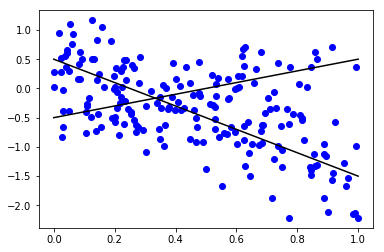

In [122]:
for i in range(0,n):
    x[i] = np.random.rand(1) 
    if np.random.rand(1) < e[0]:
        y[i] = w[0]*x[i] + b[0] + np.random.randn(1)*np.sqrt(v[0])
    else:
        y[i] = w[1]*x[i] + b[1] + np.random.randn(1)*np.sqrt(v[1])
plt.plot(x,y,'bo') 
t = np.linspace(0, 1, num=100) 
plt.plot(t,w[0]*t+b[0],'k') 
plt.plot(t,w[1]*t+b[1],'k')
plt.show()

In [138]:
#EM algorithm
it = 500 #max number of iterations
ee = np.array([0.5,0.5])
we = np.array([1.0,-1.0])
be = np.array([0.0,0.0])
ve = np.array([np.var(y),np.var(y)]) 
ll = np.zeros([it])

In [139]:
for t in range(0,it):
    print "number of iterations: " + str(t) 
    ll[t] = LogLikelihood(n,K,ee,y,we,be,ve)
    print(ll[t])
    if t>=1:
        if (ll[t]-ll[t-1]) < 10**(-4):
            break
    gam = Gam(n,K,ee,y,we,be,ve)
    ee = UpdateE(gam)
    #print(ee.shape)
    we,be,ve = UpdateWBVar(n,K,gam,y,we,be,ve)
    #print(we.shape)
    #print(be.shape)
    #print(we.shape)

number of iterations: 0
-217.47062461435215
(200, 2)
number of iterations: 1
-170.94880667909592
(200, 2)
number of iterations: 2
-168.01704680269643
(200, 2)
number of iterations: 3
-166.9976441291001
(200, 2)
number of iterations: 4
-166.1449398920319
(200, 2)
number of iterations: 5
-165.31548725335563
(200, 2)
number of iterations: 6
-164.5437340981018
(200, 2)
number of iterations: 7
-163.8678341535507
(200, 2)
number of iterations: 8
-163.2921454488045
(200, 2)
number of iterations: 9
-162.79528733297525
(200, 2)
number of iterations: 10
-162.3512549854845
(200, 2)
number of iterations: 11
-161.94444873877492
(200, 2)
number of iterations: 12
-161.57406721229776
(200, 2)
number of iterations: 13
-161.25034774127934
(200, 2)
number of iterations: 14
-160.98614918328224
(200, 2)
number of iterations: 15
-160.7880742692798
(200, 2)
number of iterations: 16
-160.65208847694728
(200, 2)
number of iterations: 17
-160.56580340589835
(200, 2)
number of iterations: 18
-160.51431950981976


In [142]:
print e,w,b,v
print ee,we,be,ve

[0.7 0.3] [-2  1] [ 0.5 -0.5] [0.2 0.1]
[0.24924751 0.75075249] [ 1.31760425 -1.97142512] [-0.6610378   0.49066607] [0.06731559 0.22444164]


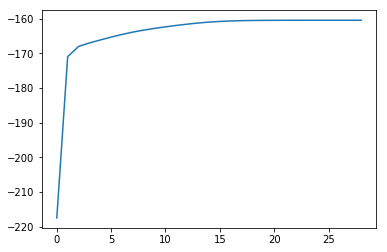

In [140]:
plt.clf()
plt.plot(ll[0:t])
plt.show()

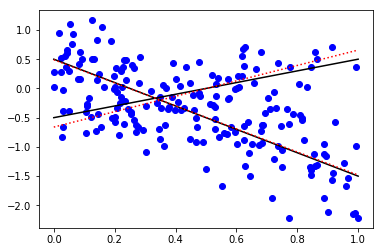

In [141]:
plt.clf()
plt.plot(x,y,'bo')
t = np.linspace(0, 1, num=100) 
plt.plot(t,w[0]*t+b[0],'k')
plt.plot(t,w[1]*t+b[1],'k')
plt.plot(t,we[0]*t+be[0],'r:')
plt.plot(t,we[1]*t+be[1],'r:')
plt.show()